In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from collections import OrderedDict

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from statsmodels.sandbox.stats.multicomp import multipletests 
from sklearn.ensemble import RandomForestClassifier

from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot

In [2]:
cell_types = ['hDL-1', 'hDL-2', 'hDL-3', 'hL2/3', 'hL4', 'hL5-1', 'hL5-2', 'hL5-3',
       'hL5-4', 'hL6-1', 'hL6-2', 'hL6-3', 'hNdnf', 'hNos', 'hPv-1',
       'hPv-2', 'hSst-1', 'hSst-2', 'hSst-3', 'hVip-1', 'hVip-2', 'unlabeled']

cell_classes = ['exci', 'exci', 'exci', 'exci', 'exci', 'exci', 'exci', 'exci',
       'exci', 'exci', 'exci', 'exci', 'inhi', 'inhi', 'inhi',
       'inhi', 'inhi', 'inhi', 'inhi', 'inhi', 'inhi', 'glia']

df_cell_class = pd.DataFrame()
df_cell_class['cell_type'] = cell_types
df_cell_class['cell_class'] = cell_classes
df_cell_class = df_cell_class.set_index('cell_type')
df_cell_class

,cell_class
cell_type,
hDL-1,exci
hDL-2,exci
hDL-3,exci
hL2/3,exci
hL4,exci
hL5-1,exci
hL5-2,exci
hL5-3,exci
hL5-4,exci


In [3]:
mcc_file = './data/binc/binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
df_mcc = pd.read_table(mcc_file, index_col=['chr', 'bin'])
print(df_mcc.shape)

/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(26058, 6435)


In [4]:
meta_file = './data/metadata/metadata_human_combined_updated.tsv' 
cluster_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain.tsv'
tsne_file = './data/tsne/tsne_perp30_binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
gene_id_name_file = './data/references/gene_id_to_names.tsv'
annotation_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain_annotation.tsv'

df_meta = pd.read_table(meta_file, index_col='Sample')
df_cluster = pd.read_table(cluster_file, index_col='sample')
df_tsne = pd.read_table(tsne_file, index_col='sample')
df_gene = pd.read_table(gene_id_name_file, index_col='geneID')
df_annot = pd.read_table(annotation_file, index_col='cluster_ID').fillna('unlabeled')

df_cluster = pd.merge(df_cluster, df_annot, left_on='cluster_ID', right_index=True)
df_cluster = pd.merge(df_cluster, df_cell_class, left_on='cluster_annotation', right_index=True)

print(df_meta.shape)
print(df_tsne.shape)
print(df_cluster.shape)
print(df_gene.shape)

df_info = pd.merge(df_meta, df_cluster, left_index=True, right_index=True)
df_info = pd.merge(df_info, df_tsne, left_index=True, right_index=True)
print(df_info.shape)

(6435, 16)
(6435, 2)
(6435, 3)
(57820, 5)
(6435, 21)


# End of preprocessing

# Analysis of variances

In [5]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

# ANOVAs for each gene and each cluster

In [6]:
# ANOVAs for each gene

# sst ssw sr_n

df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
sr_n = pd.Series()
for idx, df_sub in df_info.groupby('cluster_annotation'):
    cells = df_sub.index.values
    SSt = df_mcc[cells+'_mcc'].apply(sum_of_square, axis=1)
    SSw = 0
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        cells_bio = df_sub2.index.values
        SSw += df_mcc[cells_bio+'_mcc'].apply(sum_of_square, axis=1)
    df_sst[idx] = SSt 
    df_ssw[idx] = SSw 
    sr_n[idx] = cells.shape[0]
 

In [7]:
# F-stat, p-values

I = 3
df_F = ((df_sst - df_ssw)/(I-1))/(df_ssw.divide(sr_n-I, axis=1))
df_p = pd.DataFrame()
for col in df_F.columns:
    d2 = sr_n.loc[col] - I
    df_p[col] = df_F[col].apply(lambda x: stats.f.sf(x, I-1, d2))
df_p.head()

hDL-1     hDL-2         hL2/3       hL4     hL5-1  \
chr bin                                                             
1   700000   0.018146  0.076367  1.660014e-26  0.077878  0.038332   
    800000   0.067251  0.382282  2.053412e-32  0.145263  0.298784   
    900000   0.496751  0.259096  9.502385e-08  0.017218  0.155323   
    1000000  0.000002  0.360165  7.602027e-28  0.002600  0.031744   
    1100000  0.001188  0.455899  9.245300e-28  0.002659  0.258956   

                    hL5-2     hL5-3     hL5-4     hL6-1     hL6-2     hL6-3  \
chr bin                                                                       
1   700000   1.150080e-02  0.005060  0.000075  0.007023  0.003601  0.473640   
    800000   9.799408e-02  0.130663  0.048641  0.637465  0.168109  0.437446   
    900000   7.862552e-08  0.230850  0.000080  0.890423  0.099467  0.097800   
    1000000  5.457103e-02  0.012615  0.003071  0.105596  0.637427  0.870788   
    1100000  6.273575e-02  0.502490  0.014362  0.501264  0.276790  0.638726   

                hNdnf      hNos     hPv-1     hPv-2    hSst-2    hSst-3  \
chr bin                                                                   
1   700000   0.002232  0.016007  0.016351  0.995831  0.003435  0.000137   
    800000   0.001006  0.614743  0.402688  0.052606  0.140547  0.762787   
    900000   0.094833  0.072744  0.055230  0.965186  0.482895  0.366604   
    1000000  0.095551  0.006513  0.220825  0.950349  0.733377  0.015585   
    1100000  0.047550  0.147765  0.101202  0.072367  0.303281  0.307207   

               hVip-1    hVip-2  unlabeled  
chr bin                                     
1   700000   0.108089  0.099827   0.087988  
    800000   0.064593  0.172004   0.612387  
    900000   0.177506  0.011516   0.193829  
    1000000  0.047015  0.104930   0.949074  
    1100000  0.357883  0.732945   0.193673

In [8]:
df_sst.head()

hDL-1     hDL-2      hL2/3       hL4     hL5-1     hL5-2  \
chr bin                                                                     
1   700000   14.543521  0.922906  54.665801  8.510604  2.060784  5.284565   
    800000    6.467479  1.355363  36.065954  4.945360  1.207108  3.199626   
    900000    2.656125  0.601660  17.694874  3.046778  0.962067  2.188737   
    1000000   6.214064  0.719403  28.944558  4.854452  1.558284  2.911010   
    1100000   2.881294  0.505414  14.328605  2.559972  0.771243  2.209478   

                hL5-3     hL5-4     hL6-1     hL6-2     hL6-3      hNdnf  \
chr bin                                                                    
1   700000   4.194082  7.611102  4.245685  4.277925  1.406388  13.024803   
    800000   2.456585  5.213223  1.607820  3.793351  0.894267   8.172887   
    900000   1.427460  2.961020  1.072555  1.724935  0.782520   4.209205   
    1000000  2.793460  5.341429  1.959601  3.284217  1.125206   6.892291   
    1100000  1.189084  2.910530  0.439692  2.248263  0.657863   3.706820   

                 hNos     hPv-1     hPv-2     hSst-2    hSst-3    hVip-1  \
chr bin                                                                    
1   700000   2.155286  8.777869  1.378226  10.325005  2.995835  4.495040   
    800000   1.022808  5.418430  0.959349   5.153998  1.852499  2.387911   
    900000   0.564069  3.739878  0.498675   3.018769  1.620386  1.287432   
    1000000  1.618459  4.374091  0.591665   3.897392  1.756822  1.420972   
    1100000  0.242927  1.878160  0.226779   1.556599  0.813185  0.461322   

               hVip-2  unlabeled  
chr bin                           
1   700000   6.591586  31.529997  
    800000   6.040626  33.690116  
    900000   4.224011  19.043954  
    1000000  4.558460  16.728008  
    1100000  2.200582   7.296175

In [9]:
# eta-squard and omega squared
df_eta = 1 - df_ssw/df_sst

# om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)
I = 3
df_ome = (df_sst - df_ssw - (I-1)*df_ssw.divide(sr_n-I, axis=1))/(df_sst + df_ssw.divide(sr_n-I, axis=1))


def order_df_res(df_res):
    df_res_ordered = pd.DataFrame()
    for col in df_res.columns:
        df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    return df_res_ordered

## Plots of ANOVA

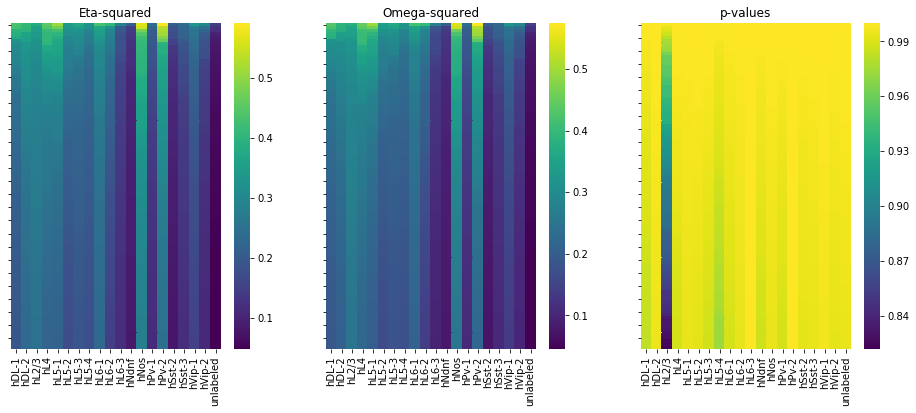

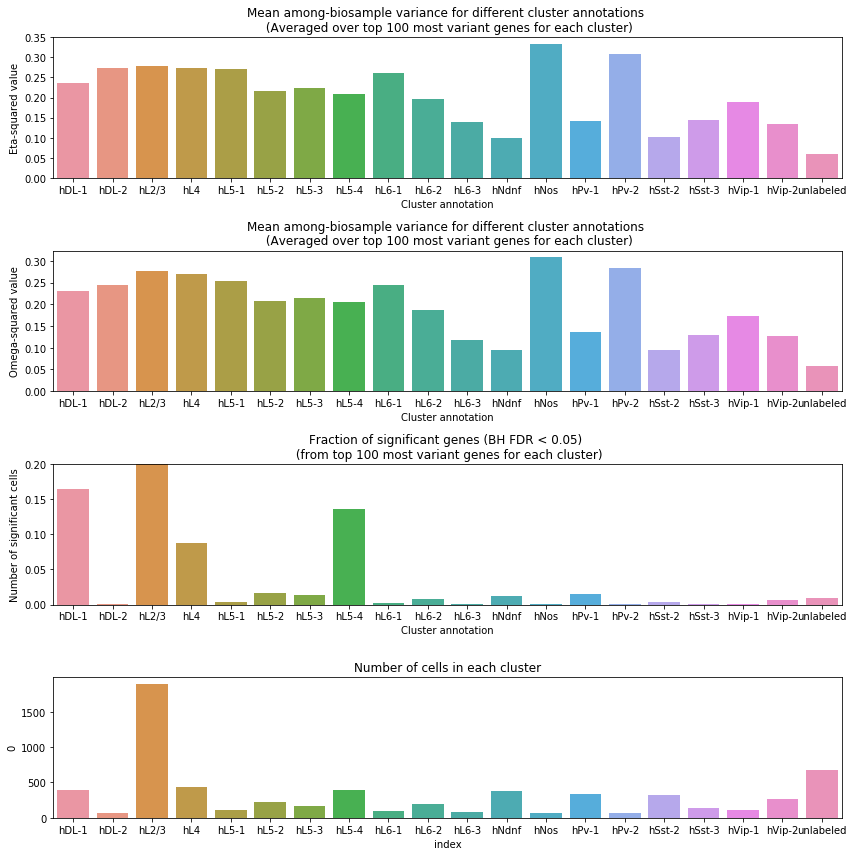

In [10]:
# eta-squared, omega-squared, and p-values 

df_res1 = df_eta
df_res2 = df_ome
df_res3 = df_p
n_top = df_res1.shape[0] 
n_top = 100 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_p.columns:
    rejs, *dis = multipletests(df_p[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax.set_ylim([0.0, 0.2])
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()



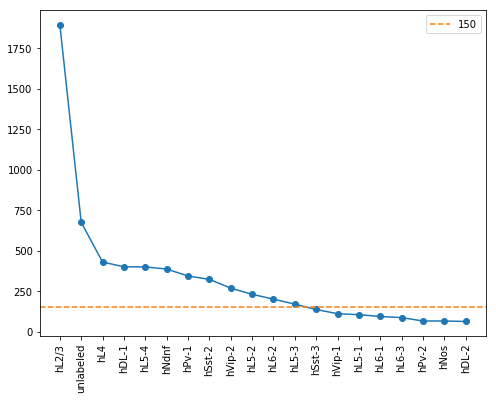

hDL-1         400
hL2/3        1894
hL4           429
hL5-2         230
hL5-3         169
hL5-4         399
hL6-2         200
hNdnf         386
hPv-1         343
hSst-2        322
hVip-2        268
unlabeled     674
dtype: int64

In [10]:
# number of cells in each cluster

sr_n_sorted = sr_n.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
# sns.barplot(x='index', y=0, data=sr_n.sort_values(ascending=False).to_frame().reset_index(), ax=ax)
# ax.set_title('Number of cells in each cluster')

ax.plot(sr_n_sorted.values, '-o')
ax.set_xticklabels(sr_n_sorted.index.values, rotation=90)
ax.set_xticks([i for i in range(sr_n.shape[0])])
ax.axhline(y=150, ls='dashed', color='C1', label='150')
ax.legend()
plt.show()

sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted > 150)].index)]
sr_n_tr

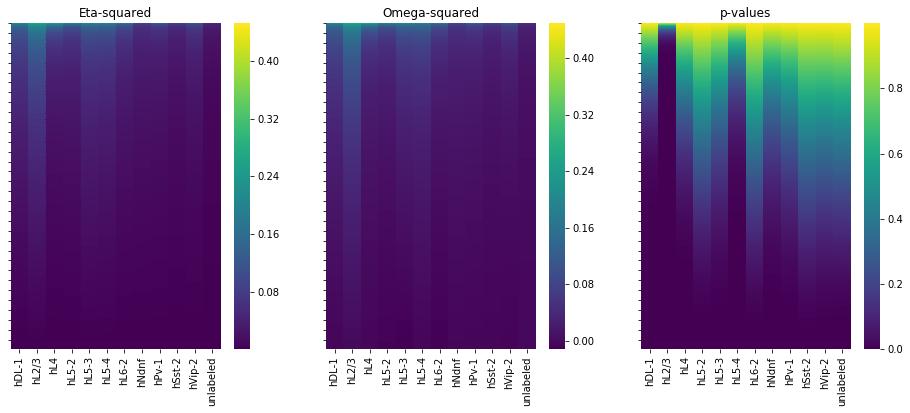

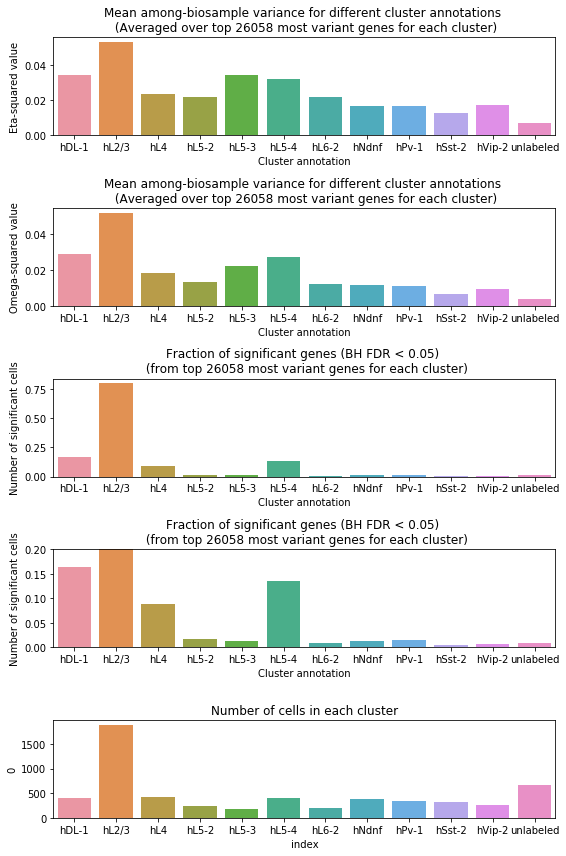

In [12]:
# rerun with truncated set of celltypes

# eta-squared, omega-squared, and p-values 

cell_types_tr = sr_n_tr.index.values  

df_res1 = df_eta[cell_types_tr]
df_res2 = df_ome[cell_types_tr]
df_res3 = df_p[cell_types_tr]
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_res3.columns:
    rejs, *dis = multipletests(df_res3[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(5, 1, figsize=(8, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax.set_ylim([0.0, 0.2])
ax = axs[4]
sns.barplot(x='index', y=0, data=sr_n_tr.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()


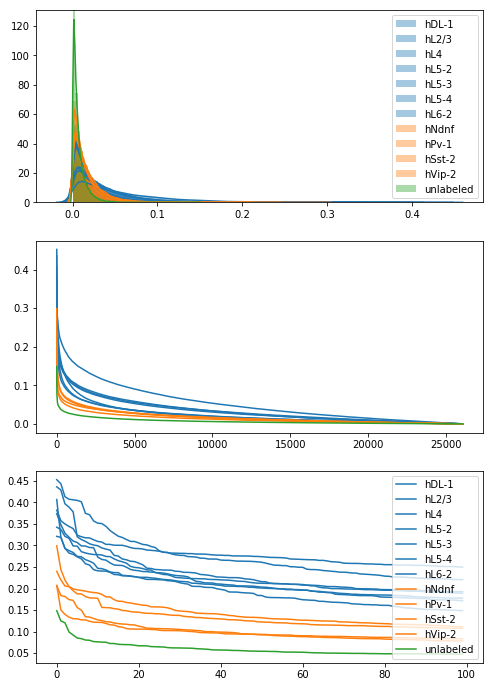

In [14]:
# eta-squared

# df_cell_class.loc[cell_types_tr].groupby('cell_class')


df_res = df_eta[cell_types_tr] 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
ax = axs[0]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'exci':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'inhi':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'glia':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C2')
ax.legend()

ax = axs[1]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'exci':
        ax.plot(df_res_ordered[col].values, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'inhi':
        ax.plot(df_res_ordered[col].values, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'glia':
        ax.plot(df_res_ordered[col].values, label=col, color='C2')
        
ax = axs[2]
n_tops = 100
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'exci':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'inhi':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'glia':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C2')
ax.legend()
plt.show()



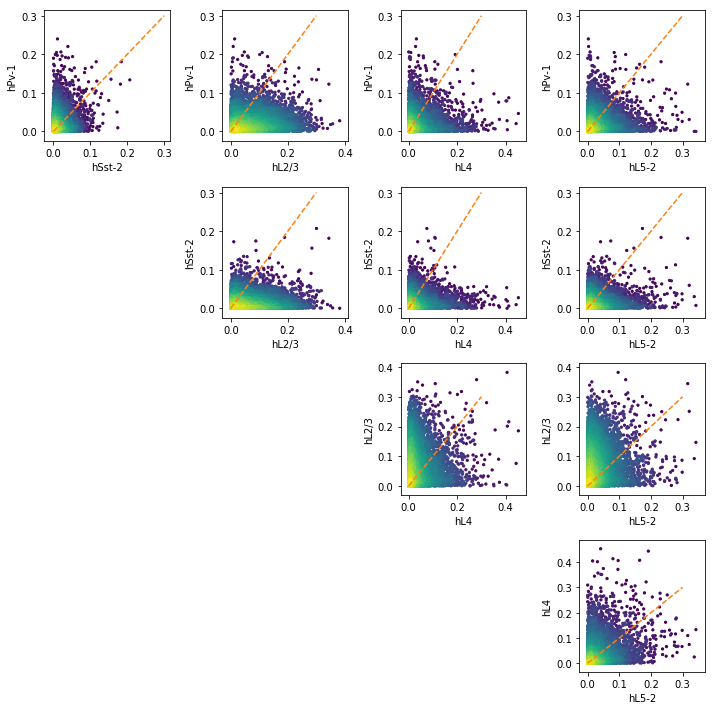

In [15]:
# hPv-1, hSst-2, hL2/3, hL4, hL5-2

cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n = len(cell_types_tr2)

fig, axs = plt.subplots(n, n, figsize=(12, 12))
for i, j in zip(*np.tril_indices_from(axs, k=0)):
    axs[i, j].set_visible(False)
for i, j in zip(*np.triu_indices_from(axs, k=1)):
    ax = axs[i, j]
    cti = cell_types_tr2[j]
    ctj = cell_types_tr2[i]
    xy = np.vstack([df_res[cti].values, df_res[ctj].values]) 
    z = gaussian_kde(xy)(xy)
    ax.scatter(df_res[cti].values, df_res[ctj].values, c=np.log10(z), s=5)
    ax.set_xlabel(cti)
    ax.set_ylabel(ctj)
    line_x = np.arange(0, 0.4, 0.1)
    line_y = np.arange(0, 0.4, 0.1)
    ax.plot(line_x, line_y, '--', color='C1')
    ax.set_aspect('auto')
    
fig.tight_layout()
plt.show()



# Look at one cell type (hL4)

In [11]:
# repeat with different n 

# take top n genes for hL4

# classifier LDA   

# evaluate

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics 
from sklearn.model_selection import KFold

# number of cells from each biosample

def get_data(celltype):
    cells = df_info[df_info.cluster_annotation==celltype].index.values
    cells_v1 = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_v1')].index.values
    cells_EA = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EA')].index.values
    cells_EB = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EB')].index.values
#     print(np.asarray([cells_v1.shape[0], cells_EA.shape[0], cells_EB.shape[0]])/cells.shape[0])

    # generate data
    cells = df_info[df_info['cluster_annotation']==celltype].index.values
    y = df_info.loc[cells, 'Biosample']
    X0 = df_mcc.loc[df_p.sample(frac=1).index.values, cells+'_mcc'].T 
    X0.index = [cell[:-len('_mcc')] for cell in X0.index]
    X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells+'_mcc'].T 
    X1.index = [cell[:-len('_mcc')] for cell in X1.index]
    df_xy0 = pd.merge(X0, y.to_frame(), left_index=True, right_index=True)
    df_xy1 = pd.merge(X1, y.to_frame(), left_index=True, right_index=True)
#     print(df_xy0.shape)
#     print(df_xy1.shape)
    return df_xy0, df_xy1
    

In [12]:

def LDA_xvalid(df_xy, n_splits=5, n_tops=np.arange(1, 100, 2)):
    """
    X = regex="^\("
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            X_train = df_xy.iloc[train_index, :n_top].filter(regex='^\(')
            X_test = df_xy.iloc[test_index, :n_top].filter(regex='^\(')
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            lda = LDA().fit(X_train, y_train)
            y_pred = lda.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f1_micros, mean_f1_macros


/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


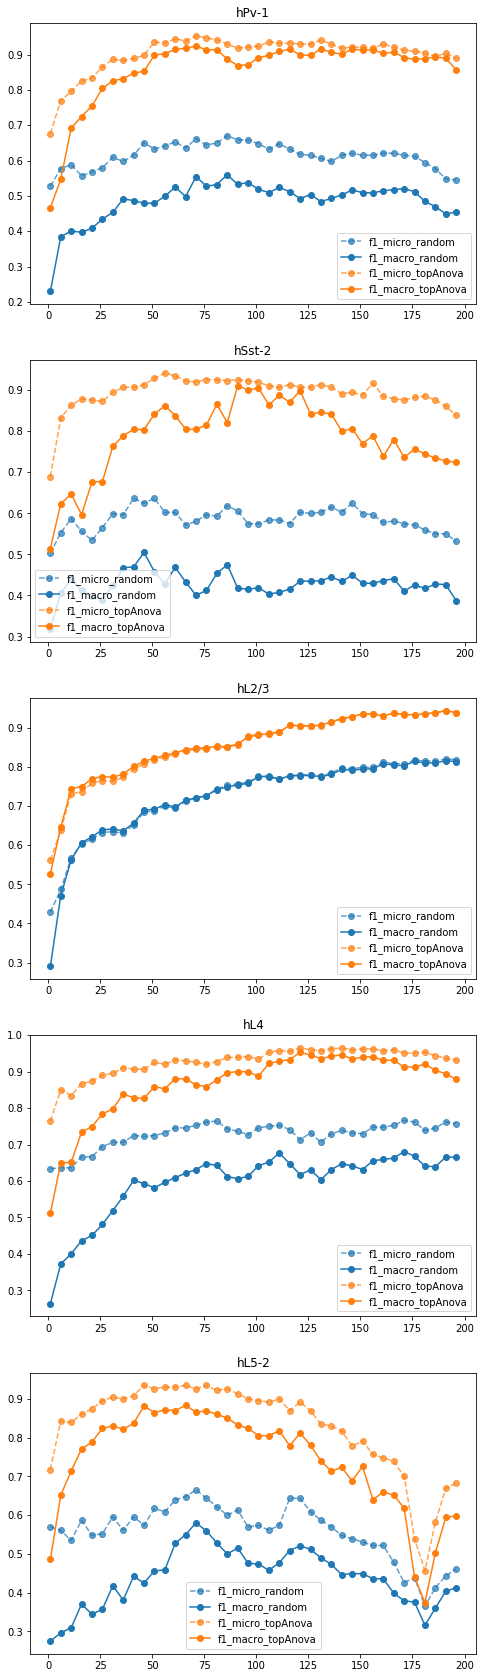

In [44]:
cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n = len(cell_types_tr2)
n_tops = np.arange(1, 200, 5)

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    accs0, f1_micros0, f1_macros0 = LDA_xvalid(df_xy0, n_tops=n_tops)
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1, n_tops=n_tops)

    ax.plot(n_tops, f1_micros0, '--o', label='f1_micro_random', color='C0', alpha=0.7)
    ax.plot(n_tops, f1_macros0, '-o', label='f1_macro_random', color='C0')
    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_topAnova', color='C1')
    ax.set_title(celltype)
    ax.legend()
plt.show()

In [49]:
# What are the top 30 genes?
n_top = 30
# sr_top_genes = df_gene.loc[df_p.hL4.sort_values().index.values[:n_top], 'geneName']
# sr_top_genes.to_frame()
df_p.hL4.sort_values().index.values[:n_top]

array([(16, 19200000), (10, 126300000), (11, 70500000), (18, 52700000),
       (4, 141800000), (17, 77300000), (17, 77100000), (6, 43800000),
       (11, 70600000), (3, 34300000), (17, 77200000), (13, 76200000),
       (4, 148700000), (18, 52500000), (5, 132800000), (3, 64300000),
       (1, 201000000), (12, 124800000), (18, 22200000), (5, 6000000),
       (3, 133000000), (11, 105600000), (3, 64600000), (18, 8700000),
       (17, 77400000), (5, 142500000), (2, 202900000), (8, 142200000),
       (4, 141900000), (6, 47900000)], dtype=object)

In [20]:
# Look at those genes in detail
# tsne and boxplot


for gene_id, gene_name in sr_top_genes.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)


NameError: name 'sr_top_genes' is not defined

In [13]:
def random_forest_xvalid(df_xy, n_splits=5, n_tops=np.arange(1, 100, 2), 
                         n_trees=10, criterion='gini'):
    """
    X = regex="^\("
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            X_train = df_xy.iloc[train_index, :n_top].filter(regex='^\(')
            X_test = df_xy.iloc[test_index, :n_top].filter(regex='^\(')
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            RFC = RandomForestClassifier(n_estimators=n_trees, criterion=criterion, random_state=1)
            rfc = RFC.fit(X_train, y_train)
            y_pred = rfc.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f1_micros, mean_f1_macros


In [14]:
def LDA_pca_xvalid(X, y, n_splits=5):
    """
    X = regex="^\("
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(y))
 
    accs = []
    f1_micros = []
    f1_macros = []
    for i, (train_index, test_index) in enumerate(split_scheme):
        X_train = X[train_index] 
        X_test = X[test_index] 
        y_train = y[train_index] 
        y_test = y[test_index] 

        # train LDA model
        lda = LDA().fit(X_train, y_train)
        y_pred = lda.predict(X_test)

        # evaluate
        acc = metrics.accuracy_score(y_test, y_pred)
        f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
        f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
        accs.append(acc)
        f1_micros.append(f1_micro)
        f1_macros.append(f1_macro)

#         if i == 0:
#             conf_mat = metrics.confusion_matrix(y_test, y_pred)
#             print(conf_mat)


    mean_acc = np.mean(accs)
    mean_f1_micro = np.mean(f1_micros)
    mean_f1_macro = np.mean(f1_macros)

    return mean_acc, mean_f1_micro, mean_f1_macro

/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', '

hPv-1


/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_

/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

hSst-2


/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


hL2/3


/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


hL4


/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', '

hL5-2


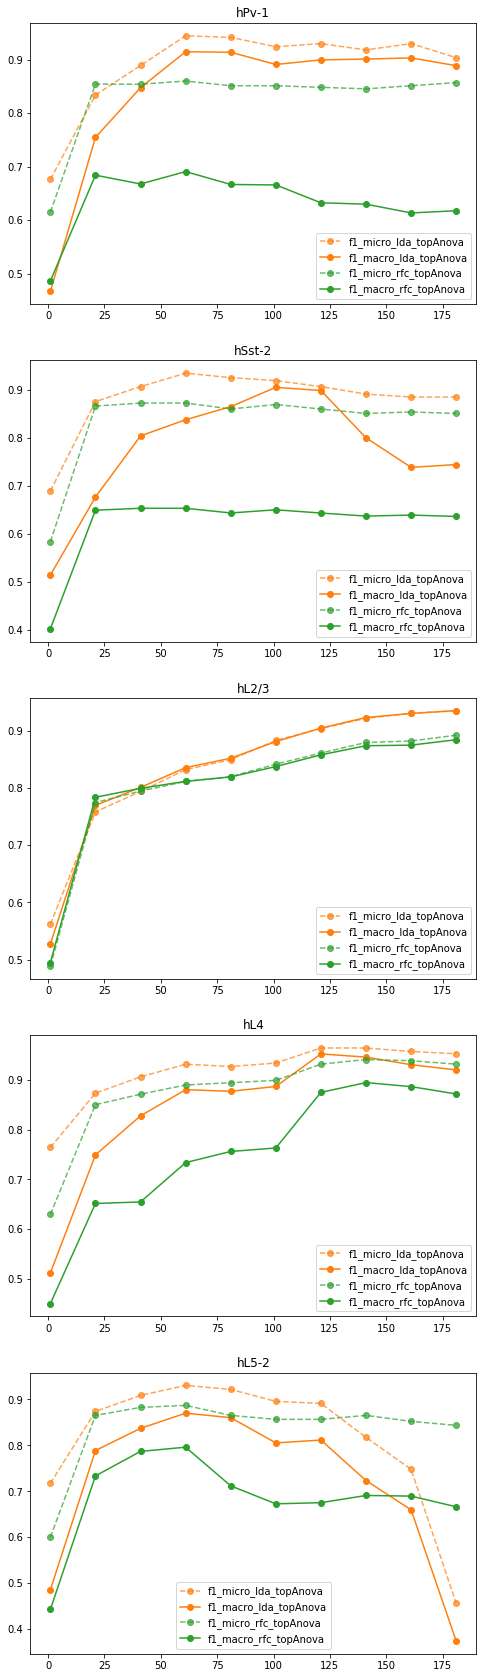

In [44]:
cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']

n = len(cell_types_tr2)
n_tops = np.arange(1, 200, 20)
n_trees = 1000

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1, n_tops=n_tops)
    accs2, f1_micros2, f1_macros2 = random_forest_xvalid(df_xy1, n_tops=n_tops, n_trees=n_trees, criterion='gini')

    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_lda_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_lda_topAnova', color='C1')
    ax.plot(n_tops, f1_micros2, '--o', label='f1_micro_rfc_topAnova', color='C2', alpha=0.7)
    ax.plot(n_tops, f1_macros2, '-o', label='f1_macro_rfc_topAnova', color='C2')
    
    ax.set_title(celltype)
    ax.legend()
    
    print(celltype)
plt.show()

In [15]:
# PCA regression
# top n PCs

n_tops = [5, 10, 20, 30, 40, 50]

# cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
cell_types_tr2 = sr_n_tr.index.values

res_dct = OrderedDict()
for celltype in cell_types_tr2:
    df_xy0, df_xy1 = get_data(celltype)
    X = df_xy1.filter(regex='^\(').values
    y = df_xy1.Biosample.values
    
    accs = []
    f1_mis = []
    f1_mas = []
    for n_top in n_tops:
        
        pca = PCA(n_components=n_top)
        pcX = pca.fit_transform(X)

        acc, f1_mi, f1_ma = LDA_pca_xvalid(pcX, y)
        accs.append(acc)
        f1_mis.append(f1_mi)
        f1_mas.append(f1_ma)
    
    res_dct[celltype] = (accs, f1_mis, f1_mas) 


/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/cndd/fangming/venvs/venv_tabla_snmcseq/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


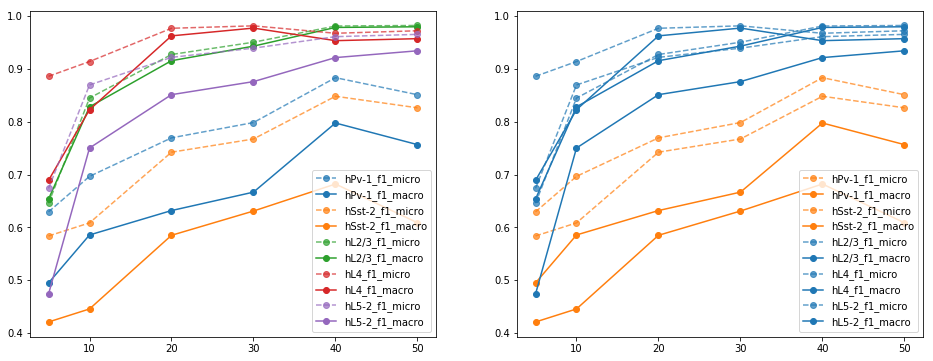

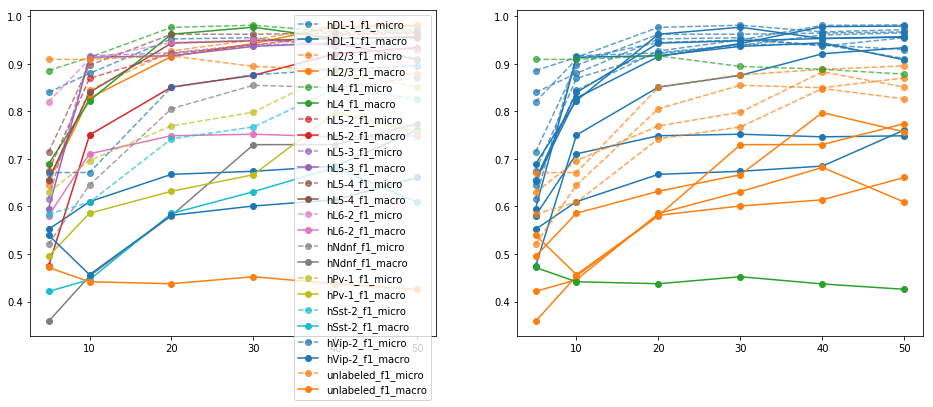

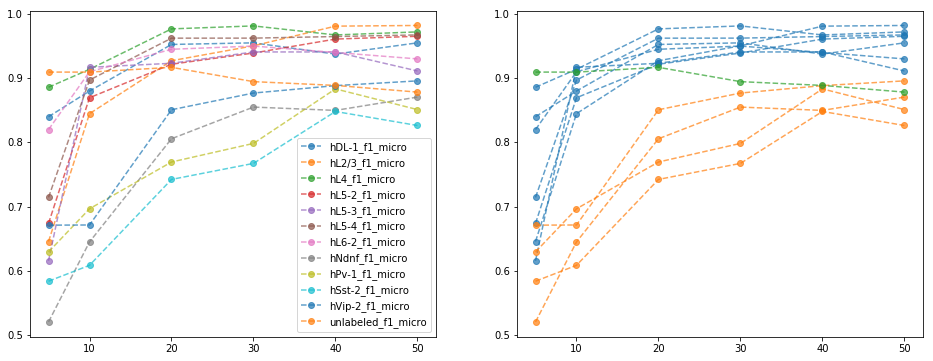

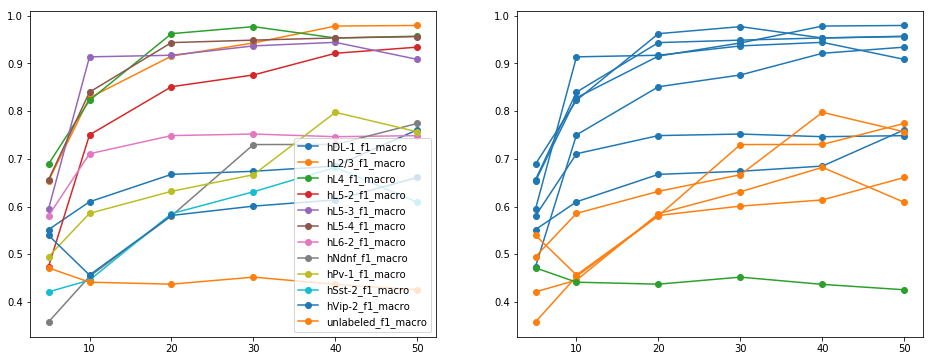

In [16]:
# cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
# n_tops = [5, 10, 20, 30, 40, 50]

# colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# ax = axs[0]
# for i, celltype in enumerate(cell_types_tr2):
#     ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i], label='{}_f1_micro'.format(celltype), alpha=0.7)
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i], label='{}_f1_macro'.format(celltype))
# ax.legend()

# ax = axs[1]
# for i, celltype in enumerate(cell_types_tr2):
#     if celltype in ['hPv-1', 'hSst-2']:
#         c = 'C0'
#     else:
#         c = 'C1'
#     ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()

# plt.show()

cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n_tops = [5, 10, 20, 30, 40, 50]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='exci'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='inhi'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
ax.legend()

plt.show()


cell_types_tr2 = sr_n_tr.index.values
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='exci'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='inhi'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()

plt.show()


cell_types_tr2 = sr_n_tr.index.values
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='exci'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='inhi'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()

plt.show()

cell_types_tr2 = sr_n_tr.index.values
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
#     ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='exci'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='inhi'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
#     ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()

plt.show()


# ICA marker genes (see if the lists converge)

1. run PCA, reduce dimensions of feature space (genes)

2. run ICA in PC spaces

3. identify certain interesting ICs
    - plot ICs against each other

    - plot IC on tSNE

4. Plot IC coefficients, look at top genes



In [ ]:
df_x = df_xy.filter(regex='^ENSG')
print(df_x.shape)
df_x.head()


In [ ]:
# ICA workflow


n_comp = 10
# fit PCA
pca = PCA(n_components=n_comp).fit(df_x)
pcs = pca.transform(df_x)

df_pc_axis = pd.DataFrame(pca.components_, 
                       index=['PC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

df_pc_axis.head()


In [ ]:
# visualize PCA
# np.cov(pcs.T)
# np.diag(np.cov(pcs.T).diagonal())



In [ ]:
# ICA after PCA and reconstruct data
# manual whitening
C = np.sqrt(np.diag(np.cov(pcs.T).diagonal()))
pcsw = np.dot(pcs, np.linalg.inv(C))
# check if whitened
# print(np.cov(pcsw.T))

# fit ICA
ica = FastICA(whiten=False).fit(pcsw)
ics = ica.transform(pcsw)
df_ics = pd.DataFrame(ics, columns=['IC'+str(i+1) for i in range(n_comp)], index=df_x.index)

axis = np.dot(np.dot(ica.components_, C), pca.components_)
df_ic_axis = pd.DataFrame(axis, 
                       index=['IC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

In [ ]:
# plot ICs

df_plot_ics = pd.merge(df_ics, df_info, left_index=True, right_index=True)
print(df_plot_ics.shape)

g = sns.pairplot(df_plot_ics[df_ics.columns.tolist() + ['Biosample']], hue='Biosample', 
                 diag_kind='kde', markers='o', size=2.5)
# print(g.axes.shape)
# for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
#     g.axes[i, j].set_visible(False)
plt.show()

In [ ]:
# plot IC tsne
plot_tsne_values(df_plot_ics, tc='IC1')

In [ ]:
# 
# look at IC1 (which seperates MB_EA from other biosamples)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
icc = df_ic_axis.loc['IC1', :].apply(np.abs).sort_values(ascending=False)
ax = axs[0]
ax.plot(icc.values, 'o-')
ax = axs[1]
ax.plot(icc.values[:100], 'o-')
ax = axs[2]
ax.plot(icc.values[:10], 'o-')
fig.tight_layout()
plt.show()

In [ ]:
# what are those genes
n_top = 30
sr_top_genes_2 = df_gene.loc[icc.index.values[:n_top], 'geneName']
sr_top_genes_2.to_frame()

In [ ]:
# tsne_box plot

for gene_id, gene_name in sr_top_genes_2.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [ ]:
# overlapping genes (genes that seperates EA from two others)

sr_top_genes_both = sr_top_genes[sr_top_genes.index.intersection(sr_top_genes_2.index)]
sr_top_genes_both.to_frame()


In [ ]:
for gene_id, gene_name in sr_top_genes_both.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [ ]:
# those that are in list 1 but not in 2 may be genes that separates bewteen MB_v1 and MB_EB

In [ ]:
# compare LDA with top ANOVA genes and LDA with random genes

In [ ]:
# find an index that show "exci v.s. inhi variance difference"

# eta-squared distribution for effect size

# if ANOVA for PV cells are skewed by few cells in MB_EB

In [ ]:
# run exactly the same analysis with mCG